# Task 1.
Raschka book chapter 14 notes and tutorials

## The Building Blocks of CNNs

### Understanding CNNs and feature hierarchies

It is common to consider CNN featuures as feature extractors. The early layers extract low-level features from raw data, and the later layers use these features to predict a continuous target value or class label.

Certain types of multilayer NNs, and in particular, deep CNNs, construct a so-called **feature hierarchy** by combining the low-level features in a layer-wise fashion to for high-livel features. 

A CNN computes feature maps from an input image, where each element comes from a local patch of pixels in the input image. This local patch of pixels is referred to as the **local receptive field**. CNNs usually perform very well on image-related tasks, largely due to two important ideas:

* **Sparse connectivity**: A single element in the feature map is connected to only a small patch of pixels.

* **Parameter sharing**: The same weights are used for different patches of the input image.

A consequence of these two ideas is that replacing a fully connected MLP with a convolutional layer substantially decreases the number of weights in the network, and we will see an improvement in the ability to capture salient features. For image data, it makes sense to assume that nearby pixels are more relevant to each other than pixels that are far away from each other.

Typically, CNNs are composed of several convolutional and sub-sampling (pooling) layers that are followed by one or more fully connected layers at the end. The fully connected layers are essentially an MLP.

### Performing discrete convolutions

A **discrete convolution** (or convolution) is a fundamental operation in a CNN.

#### Discrete convolutions in one dimension

A discrete convolution for vectors, $x$ and $w$, is denoted by $y = x \ast w$. Here, $x$ is the input, and $w$ is the filter.

A discrete convolution is mathematically defined as follows:
$$
y = x \ast w \rightarrow y[i] = \sum_{k=-\infty}^{+\infty} x[i-k] w[k]
$$
Where brackets denote the indexing for vector elements.

To correctly compute the summation in the preceding formular, it is assumed that $x$ and $w$ are filled with zeros. In practical situations, $x$ is only padded with a finite number of zeros.

This process is called *zero-padding*. Consider an input $x$ and filter $w$ with $n$ and $m$ elements respectively, where $m \leq n$. The padded vector, $x^p$, has size $n+2p$. The practical formular for computing the discrete convolution changes to the following:
$$
y = x \ast w \rightarrow y[1] = \sum_{k=0}^{k=m-1} x^p[i+m-k] w[k]
$$

#### Padding inputs to control the size of the output feature maps

Padding can be applied with any $p \geq 0$. Depending on the choice on $p$, boundary cells may be treated differently than cells in the middle of $x$.

There are three modes of padding that are commonly used in practive: *full*, *same*, and *valid*.
* In full mode, $p=m-1$. Full padding increases the dimensions of the output and is therefore rarely used in CNN architectures.

* In same padding mode, $p$ is computed according to the filter size, along with the requirement that the input size and output size are the same.

* In valid mode, $p=0$, i.e., there is no padding.

#### Determining the  size of the convolution output

The output size of a convolution is determined by the total number of times that we shift the filter, $w$, along the input vector.

The following code is a naive implementation of how to compute a 1-D convolution. The results are compared with the ```np.convolve``` function.

In [1]:
import numpy as np

In [2]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


#### Performing a discrete convolution in 2D

When we deal with 2D inputs, such as a matrix, $X_{n_1 \times n_2}$, and the filter matrix, $W_{m_1 \times m_2}$, where $m_1 \leq n_1$ and $m_2 \leq n_2$, then the matrix $Y = X \ast W$ is the result of a 2D convolution between X and W. This is defined mathematically as follows:
$$
Y = X \ast W \rightarrow Y[i, j] = \sum_{k_1=-\infty}^{+\infty} \sum_{k_2=-\infty}^{+\infty} X[i-k_1, j-k_2] w[k_1, k_2]
$$


The following code implements 2D convolution according to the naive algorithm. The ```scipy.signal``` package provides a way to compute 2D convolution via the ```scipy.signal.convolve2d``` function:

In [3]:
import scipy.signal

In [4]:
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### Subsampling layers

Subsampling is typically applied in two forms of pooling operations in CNNs: max-pooling and mean-pooling. The size of the neighborhood where the max or mean operation is performed is called the ppoling size.

Pooling has two main advantages:
* Max-pooling introduces a local invariance. This means that small changes in a local neighborhood do not change the result of max-pooling.

* Pooling decreases the size of features, which results in higher computational efficiency. Furthermore, reducing the number of features may reduce the degree of overfitting as well.

### Putting everything together — implementing a CNN

#### Working with multiple input or color channels

An input to a convolutional layer may contain one or more 2D arrays or matrices with dimensions $N_1×N_2$.  These $N_1×N_2$ matrices are called channels. Conventional implementations of convolutional layers expect a rank-3 tensor representation as an input, for example, a three-dimensional array, $X_{N_1 \times N_2 \times C_{in}}$, where $C_{in}$ is the number of input channels. If the image is colored and uses the RGB color mode, then $C_{in} = 3$ (for the red, green, and blue color channels in RGB). However, if the image is in grayscale, then we have $C_{in} = 1$, because there is only one channel with the grayscale pixel intensity values.

To incorporate multiple input channels in the convolution operation, we perform the convolution operation for each channel separately and then matrix sum the results together.

#### Regularizing an NN with L2 regularization and dropout

To use L2 regularization within a convolutional or fully connected network, you add the L2 penalty of a particular layer to the loss function in PyTorch, as follows:

In [7]:
import torch
import torch.nn as nn

In [8]:
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

Dropout is another popular technique for regularizing (deep) NNs. Dropout is usually applied to the hidden units of higher layers and works as follows: during the training phase of an NN, a fraction of the hidden units is randomly dropped at every iteration with probability $p_{drop}$. This dropout probability is determined by the user and the common choice is $p = 0.5$.  When dropping a certain fraction of input neurons, the weights associated with the remaining neurons are rescaled to account for the dropped neurons. Dropout can be interpreted as the consensus of an ensemble of models.

### Loss functions for classification

*Binary cross-entropy* is the loss function for a binary classification and *categorical cross-entropy* is the loss function for multiclass classification.

Computing the cross-entropy loss by providing the logits, and not the class-membership probabilities, is usually preferred due to numerical stability reasons.

The following code will shows how to use loss functions with two different formats, where either the logits or class-membership probabilities are given as inputs to the loss functions:

In [9]:
####### Binary Cross-entropy
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

 
####### Categorical Cross-entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w Logits): {cce_logits_loss_fn(logits, target):.4f}')
print(f'CCE (w Probas): {cce_loss_fn(torch.log(probas), target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711
CCE (w Logits): 0.5996
CCE (w Probas): 0.5996


## Implementing a deep CNN using PyTorch

### Loading MNIST dataset

In [11]:
import torchvision
from torchvision import transforms

In [12]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

### Develop a deep NN model to classify MNIST digits

In [15]:
from torch.utils.data import DataLoader

In [24]:
# create dataloaders
batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=True)
test_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=True)

In [25]:
# construct deep NN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32), 
            nn.Tanh(), 
            nn.Linear(32, 32), 
            nn.Tanh(), 
            nn.Linear(32, 16), 
            nn.Tanh(), 
            nn.Linear(16, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

nn_model = NeuralNetwork()
nn_model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [26]:
# function to train and evaluate the model
def train_and_validate(model, train_dl, valid_dl, optimizer, loss_fn, num_epochs=20):
    
    acc_hist_train = [0] * num_epochs
    loss_hist_train = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        # Training loop
        acc_train = 0
        loss_train = 0
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_train += is_correct.sum()
            loss_train += loss.item() * x_batch.size(0)  # accumulate loss
        acc_train /= len(train_dl.dataset)
        loss_train /= len(train_dl.dataset)
        
        # store accuracy and loss history
        acc_hist_train[epoch] = acc_train
        loss_hist_train[epoch] = loss_train

        # Validation loop
        acc_valid = 0
        loss_valid = 0
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                acc_valid += is_correct.sum()
                loss_valid += loss.item() * x_batch.size(0)
            acc_valid /= len(valid_dl.dataset)
            loss_valid /= len(valid_dl.dataset)
        
        # store accuracy and loss history
        acc_hist_valid[epoch] = acc_valid
        loss_hist_valid[epoch] = loss_valid
        
        print(f'Epoch [{epoch+1:0>2}/{num_epochs}], Train Loss: {loss_train:.4f}, Train Acc: {acc_train:.4f}, Valid Loss: {loss_valid:.4f}, Valid Acc: {acc_valid:.4f}')
        
    return acc_hist_train, loss_hist_train, acc_hist_valid, loss_hist_valid

In [27]:
# evaluate the model
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

ah_train, lh_train, ah_valid, lh_valid = train_and_validate(nn_model, train_dl, valid_dl, optimizer, loss_fn)

Epoch [01/20], Train Loss: 0.6349, Train Acc: 0.8411, Valid Loss: 0.2749, Valid Acc: 0.9293
Epoch [02/20], Train Loss: 0.2158, Train Acc: 0.9411, Valid Loss: 0.1869, Valid Acc: 0.9484
Epoch [03/20], Train Loss: 0.1618, Train Acc: 0.9542, Valid Loss: 0.1596, Valid Acc: 0.9543
Epoch [04/20], Train Loss: 0.1324, Train Acc: 0.9627, Valid Loss: 0.1561, Valid Acc: 0.9561
Epoch [05/20], Train Loss: 0.1142, Train Acc: 0.9680, Valid Loss: 0.1436, Valid Acc: 0.9597
Epoch [06/20], Train Loss: 0.1009, Train Acc: 0.9708, Valid Loss: 0.1445, Valid Acc: 0.9585
Epoch [07/20], Train Loss: 0.0914, Train Acc: 0.9739, Valid Loss: 0.1349, Valid Acc: 0.9611
Epoch [08/20], Train Loss: 0.0831, Train Acc: 0.9763, Valid Loss: 0.1389, Valid Acc: 0.9596
Epoch [09/20], Train Loss: 0.0745, Train Acc: 0.9781, Valid Loss: 0.1375, Valid Acc: 0.9620
Epoch [10/20], Train Loss: 0.0702, Train Acc: 0.9795, Valid Loss: 0.1472, Valid Acc: 0.9602
Epoch [11/20], Train Loss: 0.0634, Train Acc: 0.9814, Valid Loss: 0.1461, Valid 

### Develop a deep CNN model to classify MNIST digits

In [30]:
# construct the CNN model
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

In [31]:
# calculate the size of the feature maps
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [32]:
# flatten the output of the previous layer to
# prepare it for the fully connected layer
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [34]:
# add two fully connected layers with a dropout layer in between
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10))

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device) 

In [39]:
# evaluate the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9503 val_accuracy: 0.9777
Epoch 2 accuracy: 0.9849 val_accuracy: 0.9865
Epoch 3 accuracy: 0.9881 val_accuracy: 0.9891
Epoch 4 accuracy: 0.9915 val_accuracy: 0.9904
Epoch 5 accuracy: 0.9930 val_accuracy: 0.9896
Epoch 6 accuracy: 0.9944 val_accuracy: 0.9915
Epoch 7 accuracy: 0.9950 val_accuracy: 0.9915
Epoch 8 accuracy: 0.9959 val_accuracy: 0.9914
Epoch 9 accuracy: 0.9966 val_accuracy: 0.9906
Epoch 10 accuracy: 0.9964 val_accuracy: 0.9915
Epoch 11 accuracy: 0.9967 val_accuracy: 0.9914
Epoch 12 accuracy: 0.9975 val_accuracy: 0.9908
Epoch 13 accuracy: 0.9972 val_accuracy: 0.9916
Epoch 14 accuracy: 0.9979 val_accuracy: 0.9900
Epoch 15 accuracy: 0.9976 val_accuracy: 0.9927
Epoch 16 accuracy: 0.9987 val_accuracy: 0.9916
Epoch 17 accuracy: 0.9970 val_accuracy: 0.9919
Epoch 18 accuracy: 0.9984 val_accuracy: 0.9916
Epoch 19 accuracy: 0.9985 val_accuracy: 0.9911
Epoch 20 accuracy: 0.9979 val_accuracy: 0.9916


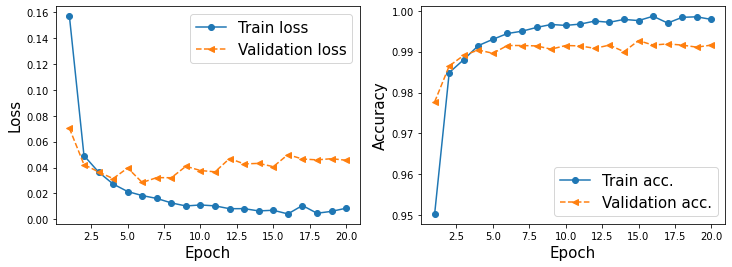

In [40]:
# visualize learning curves
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

### Explore how dropout would affect CNN model’s performance

The previous model implemented dropout, so I will now train the model wihtout dropout and see if there is a difference.

In [30]:
# construct the CNN model
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

In [41]:
# flatten the output of the previous layer to
# prepare it for the fully connected layer
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 10])

In [42]:
# add two fully connected layers with no dropout layer in between
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('fc2', nn.Linear(1024, 10))

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device) 

In [44]:
# evaluate the model
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9855 val_accuracy: 0.9896
Epoch 2 accuracy: 0.9956 val_accuracy: 0.9896
Epoch 3 accuracy: 0.9971 val_accuracy: 0.9903
Epoch 4 accuracy: 0.9973 val_accuracy: 0.9889
Epoch 5 accuracy: 0.9973 val_accuracy: 0.9925
Epoch 6 accuracy: 0.9978 val_accuracy: 0.9898
Epoch 7 accuracy: 0.9975 val_accuracy: 0.9900
Epoch 8 accuracy: 0.9977 val_accuracy: 0.9905
Epoch 9 accuracy: 0.9979 val_accuracy: 0.9890
Epoch 10 accuracy: 0.9977 val_accuracy: 0.9912
Epoch 11 accuracy: 0.9985 val_accuracy: 0.9898
Epoch 12 accuracy: 0.9980 val_accuracy: 0.9908
Epoch 13 accuracy: 0.9987 val_accuracy: 0.9891
Epoch 14 accuracy: 0.9983 val_accuracy: 0.9897
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9905
Epoch 16 accuracy: 0.9991 val_accuracy: 0.9917
Epoch 17 accuracy: 0.9988 val_accuracy: 0.9916
Epoch 18 accuracy: 0.9985 val_accuracy: 0.9905
Epoch 19 accuracy: 0.9984 val_accuracy: 0.9901
Epoch 20 accuracy: 0.9988 val_accuracy: 0.9926


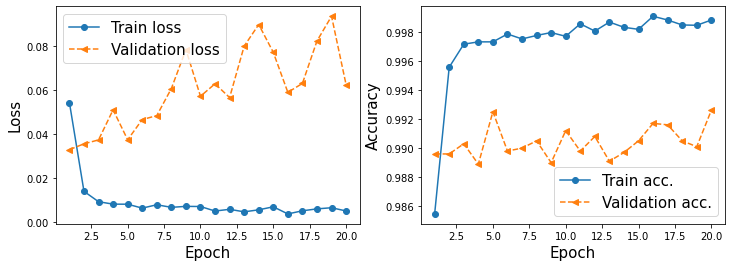

In [45]:
# visualize learning curves
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

We can see that the performance on the validation set improves and becomes much less erratic with respect to epochs when dropout is applied.